In [1]:
%load_ext autoreload
%autoreload 2

# add src to path
import sys
sys.path.append('/cluster/home/kheuto01/code/play-with-learning-army/src')
import numpy as np
# change directory to this files directory
import os
os.chdir('/cluster/home/kheuto01/code/play-with-learning-army')
from data_loader import load_processed, make_dataset, load_datasets
from embedder_registry import initialize_embedding, initialize_criteria_embedding, initialize_combiner
from domain_models import initialize_domain_models
from loss_opt import initialize_loss, initialize_optimizer
import torch
import yaml
import transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score

In [2]:
def bootstrap_metric_across_domains(y_pred, y_true, metric_func, domain_ids):
    domain_metrics = {}
    unique_domains = np.unique(domain_ids)
    print(unique_domains)
    for d in unique_domains:
        d_idx = np.where(domain_ids == d)[0]
        domain_metrics[d] = {}
        mean,low,high,domain_metrics[d]['bootstrap_scores'] = bootstrap_metric(y_pred[d_idx], y_true[d_idx], metric_func)
        domain_metrics[d]['mean'] = mean
        domain_metrics[d]['error'] =(low,high)
    return domain_metrics

#https://github.com/tufts-ml/SupContrast/blob/tmlr/bootstrap_lin_acc.py
def bootstrap_metric(y_pred, y_true, metric_func,
                     n_bootstraps=1000, rng_seed=123):
    """Compute test set boostrapping of a metric
    Args:
        y_pred (tensor): Model predictions for some output y
        y_true (tensor): True value of output y
        metric_func (function): function with parameters (y_pred, y_true)
                                returning a Tensor castable metric
        n_bootstraps (int, optional): Number of bootstrap samples to take.
                                      Defaults to 200.
        rng_seed (int, optional): Random seed for reproducibility.
                                  Defaults to 123.
    Returns:
        tuple: metric_mean: Tensor with bootstrapped mean of metric
               ci_low: Low value from 95% confidence interval
               ci_high: High value from 95% confidence interval
               b_scores: Bootstrapped metric outputs
    """
    b_scores = None
    rng = torch.random.manual_seed(rng_seed)
    # bootstrap
    for _ in range(n_bootstraps):
        sample_idx = torch.randint(y_pred.shape[0], size=(y_pred.shape[0],), generator=rng)
        score = torch.Tensor([metric_func(y_pred[sample_idx], y_true[sample_idx])])
        # store results from each run along axis 0, with other axes' shape determined by metric
        if b_scores is None:
            b_scores = score.unsqueeze(0)
        else:
            b_scores = torch.vstack((b_scores, score))
    # compute mean and confidence interval
    metric_mean = torch.mean(b_scores, dim=0)
    ci_low = torch.quantile(b_scores, 0.025, dim=0)
    ci_high = torch.quantile(b_scores, 0.975, dim=0)
    return (metric_mean, ci_low, ci_high, b_scores)


def bootstrap_dif(b_scores_1, b_scores_2):
    """Examine the difference of two bootstrapped metrics

    Args:
        b_scores_1 (Tensor): Bootstrapped metric outputs, with same seed as 2
        b_scores_2 (Tensor): Bootstrapped metric outputs, with same seed as 1
    Returns:
        tensor: True if 95% CI does not contain 0 so result is statistically significant
                False if 95% CI contains 0 so result is not statistically significant
    """
    dif_scores = b_scores_1 - b_scores_2
    # compute confidence interval of the difference
    ci_low = torch.quantile(dif_scores, 0.025, dim=0)
    ci_high = torch.quantile(dif_scores, 0.975, dim=0)
    return ~torch.logical_and(ci_low <= 0, ci_high >= 0)

In [3]:
hyper_config_mine_15 = yaml.load(open('/cluster/tufts/hugheslab/kheuto01/sensemaking/bertfinetune_test/test15_lr5e-07_alpha0.001_beta0.1/config.yaml', 'r'), Loader=yaml.FullLoader)
hyper_config_mine_20 = yaml.load(open('/cluster/tufts/hugheslab/kheuto01/sensemaking/bertfinetune_test/test20_lr5e-07_alpha0.01_beta0.01/config.yaml', 'r'), Loader=yaml.FullLoader)

In [4]:
all_results = []
all_micros = []
all_bootstraps = []
best_15_exps = ['/cluster/tufts/hugheslab/kheuto01/sensemaking/bertfinetune_test/test15_lr5e-07_alpha0.001_beta0.1',
                             '/cluster/tufts/hugheslab/kheuto01/sensemaking/bow_frozen_test/test15_lr0.001_wd0.001_bs32',
                             '/cluster/tufts/hugheslab/kheuto01/sensemaking/bow_frozen_test/test15_lr0.01_wd0.001_bsN']

best_20_exps = ['/cluster/tufts/hugheslab/kheuto01/sensemaking/bertfinetune_test/test20_lr5e-07_alpha0.01_beta0.01/',
                '/cluster/tufts/hugheslab/kheuto01/sensemaking/bow_frozen_test/test20_lr0.01_wd0.001_bsN/',
                '/cluster/tufts/hugheslab/kheuto01/sensemaking/bow_frozen_test/test20_lr0.01_wd0.001_bs128/'
                ]

for experiment_directory in best_15_exps:

    #experiment_directory = '/cluster/tufts/hugheslab/kheuto01/sensemaking/bertfinetune_test/test20_lr5e-07_alpha0.01_beta0.01'
    problem_config_path = '/cluster/home/kheuto01/code/play-with-learning-army/config/problem_config.yaml'
    test_metrics_path = os.path.join(experiment_directory, 'test_metrics.csv')
    config_path = os.path.join(experiment_directory, 'config.yaml')
    model_path = os.path.join(experiment_directory, 'final_model.pth')
    hyper_config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)
    problem_config = yaml.load(open(problem_config_path, 'r'), Loader=yaml.FullLoader)
    num_domains = problem_config['num_domains']
    train_dataset =  load_datasets(hyper_config_mine_15, train=True)[0]

    save_dict = torch.load(model_path, weights_only=False, map_location=torch.device('cpu'))
    domain_model_dict = save_dict['domain_model_dict']
    if 'embed_func' in save_dict:
        embedder = save_dict['embed_func']
        embedder.model.eval()
    else:
        embedder = initialize_embedding(hyper_config, *train_dataset)
    embedder.device = 'cpu'

    processed_test_features, processed_test_labels = load_processed(hyper_config_mine_15['test_x_file'], 
                                                                hyper_config_mine_15['test_y_file'])
    (xs, ys, problem_ids, student_ids) = make_dataset(processed_test_features, processed_test_labels)
    xs, ys, problem_ids, student_ids = embedder.preprocess_data((xs, ys, torch.tensor(problem_ids), torch.tensor(student_ids)), hyper_config)

    all_preds, all_labels, all_weights, all_domains = [], [], [], []

    if isinstance(xs, transformers.BatchEncoding):
        batch_length = len(next(iter(xs.values())))
    else:
        batch_length = len(xs)
        
    for i in range(batch_length):
        if isinstance(xs, transformers.BatchEncoding):
            x = {k: v[i].unsqueeze(0) for k, v in xs.items()}
        else:
            x = xs[i].unsqueeze(0)
        y = ys[i]
        p = problem_ids[i]
        s = student_ids[i]

        x_embed = embedder.forward(x)

        criteria_counter = 0
        for d in range(num_domains):
            num_criteria = problem_config['problems'][p]['domains'][d]["num_criteria"]
            for c in range(num_criteria):
                c_embed = torch.tensor([c])
                final_representation = torch.cat((x_embed, c_embed.unsqueeze(0)), dim=1)
                y_pred = domain_model_dict[d](final_representation)
                weight = 1/num_criteria

                all_preds.append(y_pred.detach().cpu().numpy())
                all_labels.append(y[criteria_counter].cpu().numpy())
                all_weights.append(weight)
                all_domains.append(d)
                criteria_counter += 1

    all_preds_np = np.concatenate(all_preds).flatten()
    all_labels_np = np.array(all_labels).flatten()
    all_labels = torch.tensor(np.array(all_labels)).squeeze()
    all_preds = torch.tensor(all_preds).squeeze()

    domain_auprc = bootstrap_metric_across_domains(all_labels, all_preds, average_precision_score, all_domains)
    micro_auprc, micro_auprc_low, micro_auprc_high, micro_auprc_scores = bootstrap_metric(all_labels, all_preds, average_precision_score)
    all_micros.append((micro_auprc, (micro_auprc_low, micro_auprc_high)))
    results = [(domain_auprc[d]['mean'], domain_auprc[d]['error']) for d in range(8)]

    all_results.append(results)
    all_bootstraps.append(micro_auprc_scores)


/tmp/ipykernel_179255/1546165309.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  all_preds = torch.tensor(all_preds).squeeze()


[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

In [5]:
for name, (mean, (low, high)) in zip(['finetune', 'bow', 'frozen'], all_micros):
    print(f'{name} micro auprc: {mean.item():.3f} CI {low.item():.3f}, {high.item():.3f}')

finetune micro auprc: 0.872 CI 0.836, 0.905
bow micro auprc: 0.829 CI 0.786, 0.869
frozen micro auprc: 0.858 CI 0.817, 0.894


In [6]:
for name, (mean, (low, high)) in zip(['finetune', 'bow', 'frozen'], all_micros):
    print(f'{name} micro auprc: {mean.item():.3f} CI {low.item():.3f}, {high.item():.3f}')

finetune micro auprc: 0.872 CI 0.836, 0.905
bow micro auprc: 0.829 CI 0.786, 0.869
frozen micro auprc: 0.858 CI 0.817, 0.894


In [5]:
fine_results = all_results[0]
bow_results = all_results[1]
frozen_results = all_results[2]

fine_bootstraps = all_bootstraps[0]
bow_bootstraps = all_bootstraps[1]
frozen_bootstraps = all_bootstraps[2]

# convert all tensors to scalars
fine_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in fine_results]
bow_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in bow_results]
frozen_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in frozen_results]

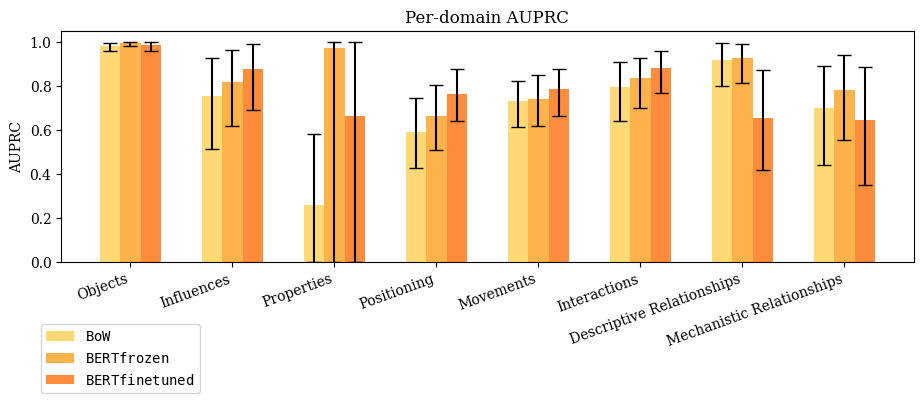

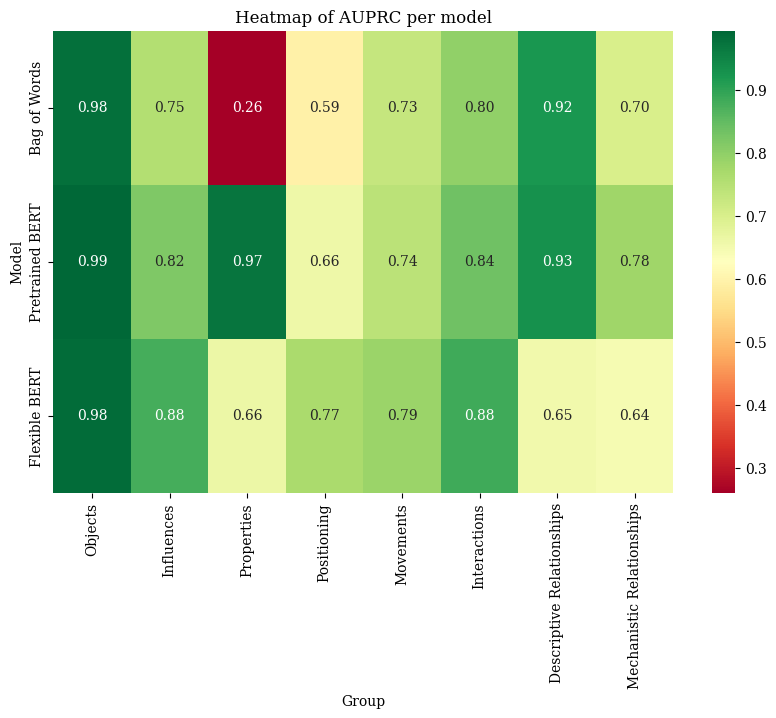

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grouped_bar_chart(list1, list2, list3):
    plt.rcParams['font.family'] = 'Serif'

    # Extract means and error bars
    means1, lows1, highs1 = zip(*[(mean, low, high) for mean, (low, high) in list1])
    means2, lows2, highs2 = zip(*[(mean, low, high) for mean, (low, high) in list2])
    means3, lows3, highs3 = zip(*[(mean, low, high) for mean, (low, high) in list3])

    # Calculate error bars
    errors1 = [np.array(means1) - np.array(lows1), np.array(highs1) - np.array(means1)]
    errors2 = [np.array(means2) - np.array(lows2), np.array(highs2) - np.array(means2)]
    errors3 = [np.array(means3) - np.array(lows3), np.array(highs3) - np.array(means3)]

    # X locations for the groups
    ind = np.arange(len(means1))
    width = 0.2

    fig, ax = plt.subplots()
    # make figure 8 in wide and 3 in tall
    fig.set_size_inches(11, 3)

    # Plot bars with error bars
    bar1 = ax.bar(ind - width, means1, width, yerr=errors1, label=r'$\mathtt{BoW}$', capsize=5, color='#fed976')
    bar2 = ax.bar(ind, means2, width, yerr=errors2, label=r'$\mathtt{BERTfrozen}$', capsize=5, color='#feb24c')
    bar3 = ax.bar(ind + width, means3, width, yerr=errors3, label=r'$\mathtt{BERTfinetuned}$', capsize=5, color='#fd8d3c')

    # Add labels and title
    ax.set_ylabel('AUPRC')
    ax.set_title('Per-domain AUPRC')
    ax.set_xticks(ind)
    ax.set_xticklabels(['Objects', 'Influences', 'Properties', 'Positioning', 'Movements', 'Interactions', 'Descriptive Relationships', 'Mechanistic Relationships'])
    ax.legend(bbox_to_anchor=(.1, -.35), loc="lower left",
                bbox_transform=fig.transFigure, ncol=1)

    # Rotate x tick labels
    ax.tick_params(axis='x', rotation=20,)
    # horizontal align tick labels right
    plt.xticks(ha='right')
    
    plt.savefig('PerDomainBarChart.pdf', bbox_inches='tight')
    plt.show()

def plot_heatmap(list1, list2, list3):
    # Extract means
    means1 = [mean for mean, _ in list1]
    means2 = [mean for mean, _ in list2]
    means3 = [mean for mean, _ in list3]

    # Combine means into a single array
    data = np.array([means1, means2, means3])

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, xticklabels=['Objects', 'Influences', 'Properties', 'Positioning', 'Movements', 'Interactions', 'Descriptive Relationships', 'Mechanistic Relationships'], yticklabels=['Bag of Words', 'Pretrained BERT', 'Flexible BERT'], ax=ax)

    # Add labels and title
    ax.set_xlabel('Group')
    ax.set_ylabel('Model')
    ax.set_title('Heatmap of AUPRC per model')

    plt.show()

# Plot the chart
plot_grouped_bar_chart(bow_results, frozen_results, fine_results)
plot_heatmap(bow_results, frozen_results, fine_results)


In [9]:
fine_minus_frozen = fine_bootstraps - frozen_bootstraps
fine_minus_bow = fine_bootstraps - bow_bootstraps
frozen_minus_bow = frozen_bootstraps - bow_bootstraps

print(f'Average (95CI), Finetune - Frozen {fine_minus_frozen.mean().item():.3f} ({fine_minus_frozen.quantile(0.025).item():.3f}, {fine_minus_frozen.quantile(0.975).item():.3f})')
print(f'Average (95CI), Finetune - Bow {fine_minus_bow.mean().item():.3f} ({fine_minus_bow.quantile(0.025).item():.3f}, {fine_minus_bow.quantile(0.975).item():.3f})')
print(f'Average (95CI), Frozen - Bow {frozen_minus_bow.mean().item():.3f} ({frozen_minus_bow.quantile(0.025).item():.3f}, {frozen_minus_bow.quantile(0.975).item():.3f})')

Average (95CI), Finetune - Frozen 0.014 (-0.010, 0.038)
Average (95CI), Finetune - Bow 0.043 (0.015, 0.072)
Average (95CI), Frozen - Bow 0.029 (0.001, 0.058)


In [10]:
all_domain_properties = problem_config['problems'][0]['domains']
for d in range(num_domains):
    print(f"Domain {all_domain_properties[d]['name']}")
    print(f"AUPRC: {domain_auprc[d]['mean']} +/- {domain_auprc[d]['std_err']}")
    print(f"Properties: {all_domain_properties[d]}")
    print("\n")

Domain Objects


KeyError: 'std_err'

In [24]:
print(f'micro_auprc: {micro_auprc} ({micro_auprc_low}, {micro_auprc_high})')

micro_auprc: tensor([0.8292]) (tensor([0.7865]), tensor([0.8689]))


In [ ]:
import matplotlib.font_manager as fm
print(sorted([f.name for f in fm.fontManager.ttflist]))

['DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'Goha-Tibeb Zemen', 'STIXGeneral', 'STIXGeneral', 'STIXGeneral', 'STIXGeneral', 'STIXNonUnicode', 'STIXNonUnicode', 'STIXNonUnicode', 'STIXNonUnicode', 'STIXSizeFiveSym', 'STIXSizeFourSym', 'STIXSizeFourSym', 'STIXSizeOneSym', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'STIXSizeTwoSym', 'cmb10', 'cmex10', 'cmmi10', 'cmr10', 'cmss10', 'cmsy10', 'cmtt10']


In [10]:
dir(fm)

['BytesIO',
 'FontEntry',
 'FontManager',
 'FontProperties',
 'MSFolders',
 'MSFontDirectories',
 'MSUserFontDirectories',
 'Number',
 'OSXFontDirectories',
 'Path',
 'X11FontDirectories',
 '_HOME',
 '_JSONEncoder',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_afm',
 '_api',
 '_cached_realpath',
 '_cleanup_fontproperties_init',
 '_get_font',
 '_get_fontconfig_fonts',
 '_get_macos_fonts',
 '_get_win32_installed_fonts',
 '_json_decode',
 '_load_fontmanager',
 '_log',
 '_validators',
 '_weight_regexes',
 'afmFontProperty',
 'annotations',
 'b64encode',
 'cbook',
 'copy',
 'dataclasses',
 'findSystemFonts',
 'findfont',
 'fontManager',
 'font_family_aliases',
 'font_scalings',
 'ft2font',
 'functools',
 'generate_fontconfig_pattern',
 'get_font',
 'get_font_names',
 'get_fontext_synonyms',
 'is_opentype_cff_font',
 'json',
 'json_dump',
 'json_load',
 'list_fonts',
 'logging',
 'lru_cache',
 'mpl',
 'os',
 'parse_fontc

In [11]:
fm.get_font_names()

['cmex10',
 'cmtt10',
 'DejaVu Sans Mono',
 'STIXSizeFiveSym',
 'DejaVu Serif Display',
 'STIXNonUnicode',
 'cmss10',
 'STIXSizeThreeSym',
 'STIXGeneral',
 'STIXSizeFourSym',
 'cmsy10',
 'DejaVu Sans Display',
 'STIXSizeOneSym',
 'DejaVu Sans',
 'Goha-Tibeb Zemen',
 'cmmi10',
 'cmb10',
 'cmr10',
 'STIXSizeTwoSym',
 'DejaVu Serif']

In [ ]:
import matplotlib
matplotlib.font_manager.get_cachedir()

AttributeError: module 'matplotlib.font_manager' has no attribute 'get_cachedir'

In [ ]:
matplotlib.font_manager._fmcache

AttributeError: module 'matplotlib.font_manager' has no attribute '_fmcache'

In [13]:
matplotlib.font_manager.get_font_names()

NameError: name 'matplotlib' is not defined

In [14]:
import matplotlib
matplotlib.font_manager.get_font_names()

['cmex10',
 'cmtt10',
 'DejaVu Sans Mono',
 'STIXSizeFiveSym',
 'DejaVu Serif Display',
 'STIXNonUnicode',
 'cmss10',
 'STIXSizeThreeSym',
 'STIXGeneral',
 'STIXSizeFourSym',
 'cmsy10',
 'DejaVu Sans Display',
 'STIXSizeOneSym',
 'DejaVu Sans',
 'Goha-Tibeb Zemen',
 'cmmi10',
 'cmb10',
 'cmr10',
 'STIXSizeTwoSym',
 'DejaVu Serif']

In [1]:
import shutil
import matplotlib

shutil.rmtree(matplotlib.get_cachedir())

In [3]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))